# Préparation 
En local, télécharger le fichier spark-apach https://spark.apache.org/downloads.html.<br>
Rajouter export PYSPARK_DRIVER_PYTHON=jupyter & export PYSPARK_DRIVER_PYTHON_OPTS='notebook' <br>
Dans spark/bin lancer ./pyspark depuis le terminal

In [3]:
# Principaux import
import pyspark
import findspark
from pyspark.sql import SparkSession 
from pyspark import SparkConf 
from pyspark.ml.classification import *
from pyspark.ml.feature import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# pour les dataframe et udf
from pyspark.sql import *  
from pyspark.mllib.evaluation import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.evaluation import *
from functools import reduce

from datetime import *

# pour le chronomètre
import time

# initialise les variables d'environnement pour spark
findspark.init()

# Démarrage session spark 
# --------------------------
def demarrer_spark():
    local = "local[*]"
    appName = "Project BDLE"
    configLocale = SparkConf().setAppName(appName).setMaster(local).\
    set("spark.executor.memory", "6G").\
    set("spark.driver.memory","6G").\
    set("spark.sql.catalogImplementation","in-memory")
  
    spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
    sc = spark.sparkContext
    sc.setLogLevel("ERROR")
  
    spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

  # On ajuste l'environnement d'exécution des requêtes à la taille du cluster (4 coeurs)
    spark.conf.set("spark.sql.shuffle.partitions","4")    
    print("session démarrée, son id est ", sc.applicationId)
    return spark
spark = demarrer_spark()

session démarrée, son id est  local-1636618282331


In [4]:
# on utilise 8 partitions au lieu de 200 par défaut
spark.conf.set("spark.sql.shuffle.partitions", "8")
print("Nombre de partitions utilisées : ", spark.conf.get("spark.sql.shuffle.partitions"))

Nombre de partitions utilisées :  8


# Lecture et Pré-traitement
### Adult Census Income 
Ces données ont été extraites de la base de données du bureau du recensement de 1994 par Ronny Kohavi et Barry Becker (Data Mining and Visualization, Silicon Graphics). La tâche de prédiction consiste à déterminer si une personne gagne plus de 50 000 $ par an.

À noter que ces données en question sont déséquilibré, ils existent plus de personnes gagnant moins de 50K\\$ l'année que plus de 50K\\$

Age: Discret (de 17 à 90)<br>
workClass (Private, Federal-Government, etc): catégorielle (7 catégories)<br>
Final Weight (le nombre de personnes que le recensement estime que l'entrée représente): Continue<br>
Education (le diplome le plus haut obtenu): Ordinal (16 catégories)<br>
Education Number (le nombre d'année d'étude): Discret (de 1 à 16)<br>
Marital Status: catégorielle (7 catégories)<br>
Occupation (Transport-Moving, Craft-Repair, etc): catégorielle (14 catégories)<br>
Relationship (situation famiale): Nominal (6 catégories)<br>
Race: catégorielle (5 catégories)<br>
Sex: catégorielle (2 catégories)<br>
Capital Gain: Continue<br>
Capital Loss: Continue<br>
Hours per week: Discret (de 1 à 99)<br>
Native Country: catégorielle (42 pays)<br>
Income (salaire soit <= ou > 50K\\$ anneé)<br>

In [104]:
Schema = StructType([
  StructField("age", IntegerType(),True),
  StructField("workClass", StringType(),True),
  StructField("fnlwgt", IntegerType(),True),
  StructField("education", StringType(),True),
  StructField("education-num", IntegerType(),True),
  StructField("marital-status", StringType(),True),
  StructField("occupation", StringType(),True),
  StructField("relationship", StringType(),True),
  StructField("race", StringType(),True),
  StructField("sex", StringType(),True),
  StructField("capital-gain", IntegerType(),True),
  StructField("capital-loss", IntegerType(),True),
  StructField("hours-per-week", IntegerType(),True),
  StructField("native-country", StringType(),True),
  StructField("salary", StringType(),True)
])



df_data=pd.read_csv('/Users/addadyouva/Downloads/BDLE/Adult.csv',header=None,na_values='?',skipinitialspace=True)
df_data[14]=df_data[14].apply(lambda x: x.replace('.',''))

In [6]:
print(f'Données total dans le train: {len(df_data)}, Données sans les valeurs manquantes dans le train: {len(df_data.dropna())}, ratio',1-len(df_data.dropna())/len(df_data))

Données total dans le train: 48842, Données sans les valeurs manquantes dans le train: 45222, ratio 0.07411653904426518


Comme le taux de valeur manquante est négligeable, nous pouvons directement supprimer ces valeurs.<br>
Par ailleur nous utilisons directement la fonction Spark "DataFrame.randomSplit(weights, seed=None)" qui prend en paramétre une list de poids pour décomposer notre dataset en train et test afin de pouvoir tester la généralisation de notre modéle.<br> 

In [92]:
Adult_data=spark.createDataFrame(df_data.dropna(),schema=Schema)
Adult_data.printSchema()
Adult_data.toPandas()

root
 |-- age: integer (nullable = true)
 |-- workClass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- salary: string (nullable = true)



,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,33,Private,245211,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,<=50K
45218,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
45219,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
45220,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


Nous pouvons remarque le déséquilibre des classes, ou donc il existe plus de personne gagnant moins 50K$ l'année que ceux gagnant plus, ce qui complique la tache de classification parce que, les algorithmes de supervision vont majoritairement prédire qu'une personne gagne moins de 50K\\$ que plus (il est plus probable qu'une personne gagne moins de 50K\\$ que plus). Donc la mesure f1 sera plus représentative nous utiliserons cette derniére afin d'évaluer notre modéle.<br>
Par Ailleur l'évaluateur de pyspark binaryClassification ne posséde que deux métrique la courbe roc et PR, nous aurions pus utiliser l'évaluateur MultiClassification, mais nous allons calculer la FMeasure avec des fonctions prédéfinis par nous.

In [8]:
Adult_data.groupBy(col('salary')).agg(count('*').alias('nb_example')).show()

+------+----------+
|salary|nb_example|
+------+----------+
| <=50K|     34014|
|  >50K|     11208|
+------+----------+



In [9]:
inf=Adult_data.where('salary like"<=50K"').count()
sup=Adult_data.where('salary like">50K"').count()
print(f'un ratio de {inf/(sup+inf)} pour les inferieurs a 50K et {sup/(sup+inf)} pour les superieurs a 50K ')

un ratio de 0.7521560302507629 pour les inferieurs a 50K et 0.2478439697492371 pour les superieurs a 50K 


# statistiques descriptive  des données

Une description rapide des données de train ainsi que l'histogramme des column avec object continue (int, float....)

In [14]:
df=Adult_data.toPandas()
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,4.522200e+04,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,1.897347e+05,10.118460,1101.430344,88.595418,40.938017
std,13.217870,1.056392e+05,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.173882e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783160e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.379260e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'fnlwgt'}>],
       [<AxesSubplot:title={'center':'education-num'}>,
        <AxesSubplot:title={'center':'capital-gain'}>],
       [<AxesSubplot:title={'center':'capital-loss'}>,
        <AxesSubplot:title={'center':'hours-per-week'}>]], dtype=object)

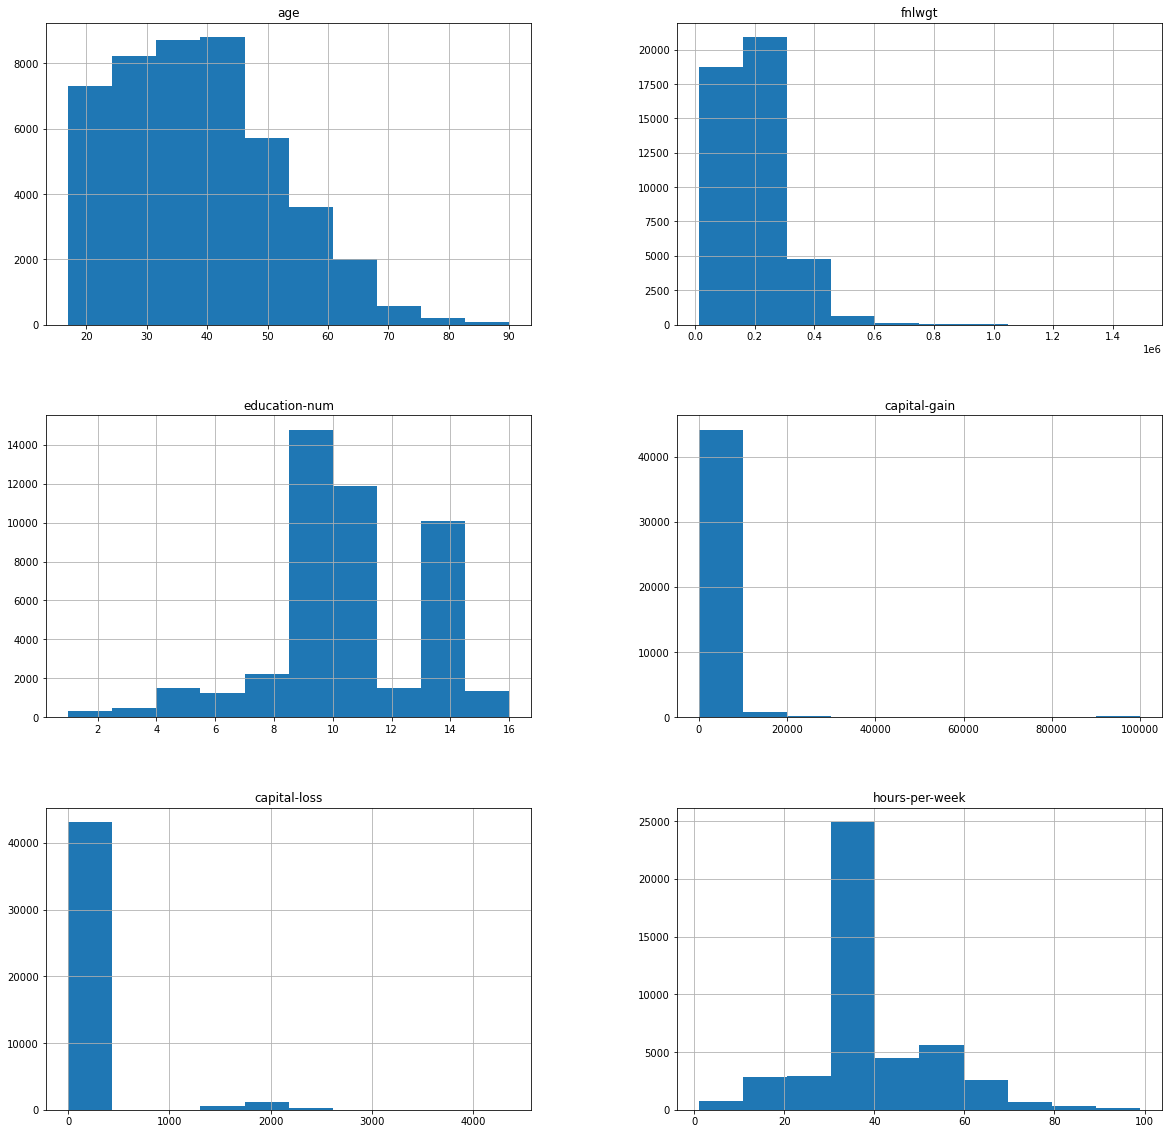

In [15]:
df.hist(figsize=(20,20))

# Salaire par rapport a la classe de travail.

la workclasse private est majoritaire comparer a toute les autres, nous remarquons meme un fort déséquilibrée entre la workclass private, mais toute les autres sont bien équilibrer

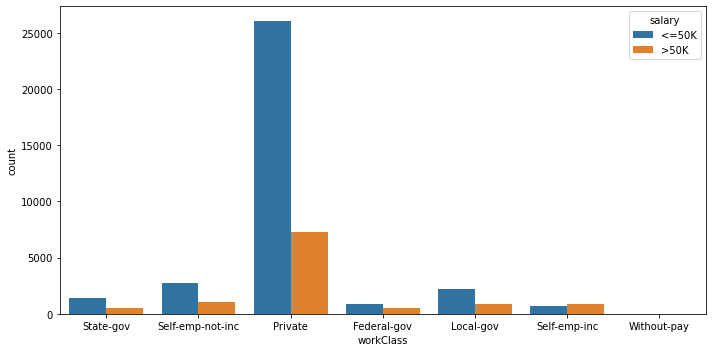

In [16]:
plt.figure(figsize=(10,5))
sns.countplot(x='workClass', hue='salary', data=df)
plt.tight_layout()
plt.show()

# Salaire par rapport aux type de diplome

Même remarque que précedemment pour le dernier diplome obtenu, auquel cas la majoriter des personnes gagnant plus de 50K\\$ ont un bachlor, les personnes gagnant moins ont un niveau soit de HS-grad ou de Some-college

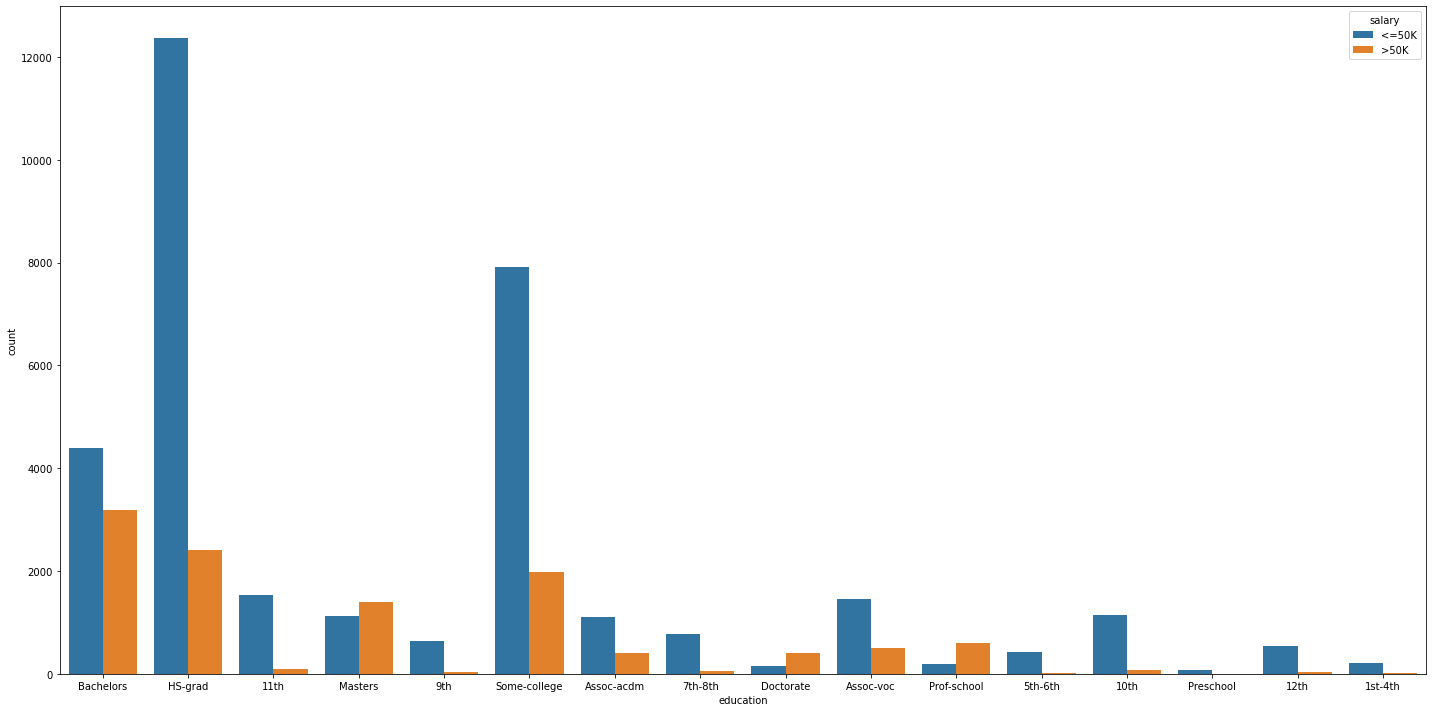

In [17]:
plt.figure(figsize=(20,10))
sns.countplot(x='education', hue='salary', data=df)
plt.tight_layout()
plt.show()

# Salaire par heur de travaille par semaine

Les personnes travaillant plus ou moins 40 heures gagnes plus de 50K comparer aux autres, mais meme remarque que pour les moins de 50K, cela veut dire que une semaine de travaille aux USA est de en moyenne 40 heures

<AxesSubplot:xlabel='hours-per-week', ylabel='salary'>

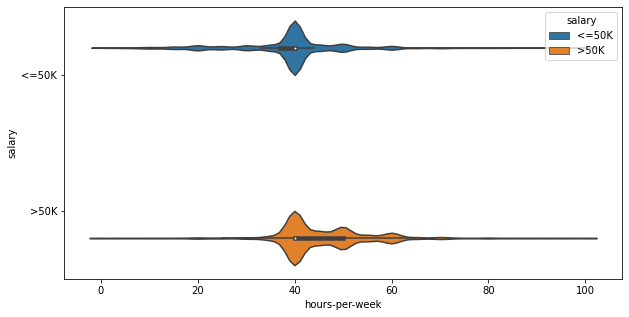

In [18]:
plt.figure(figsize=(10,5))
sns.violinplot(x='hours-per-week',y='salary',hue='salary',data=df)

# Salaire par rapport au sexe

Ils existent plus de garçon gagnant plus de 50K comparer aux femmes.

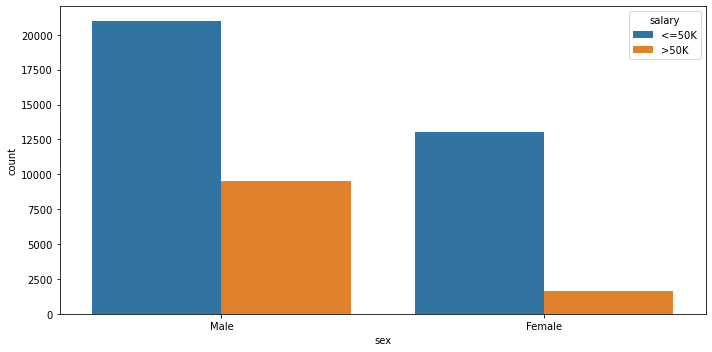

In [19]:
plt.figure(figsize=(10,5))
sns.countplot(x='sex', hue='salary', data=df)
plt.tight_layout()
plt.show()

# Salaire par rapport a l'occupation

Par rapport aux occupations les classes sont relativement bien repartie est bien équilibrer

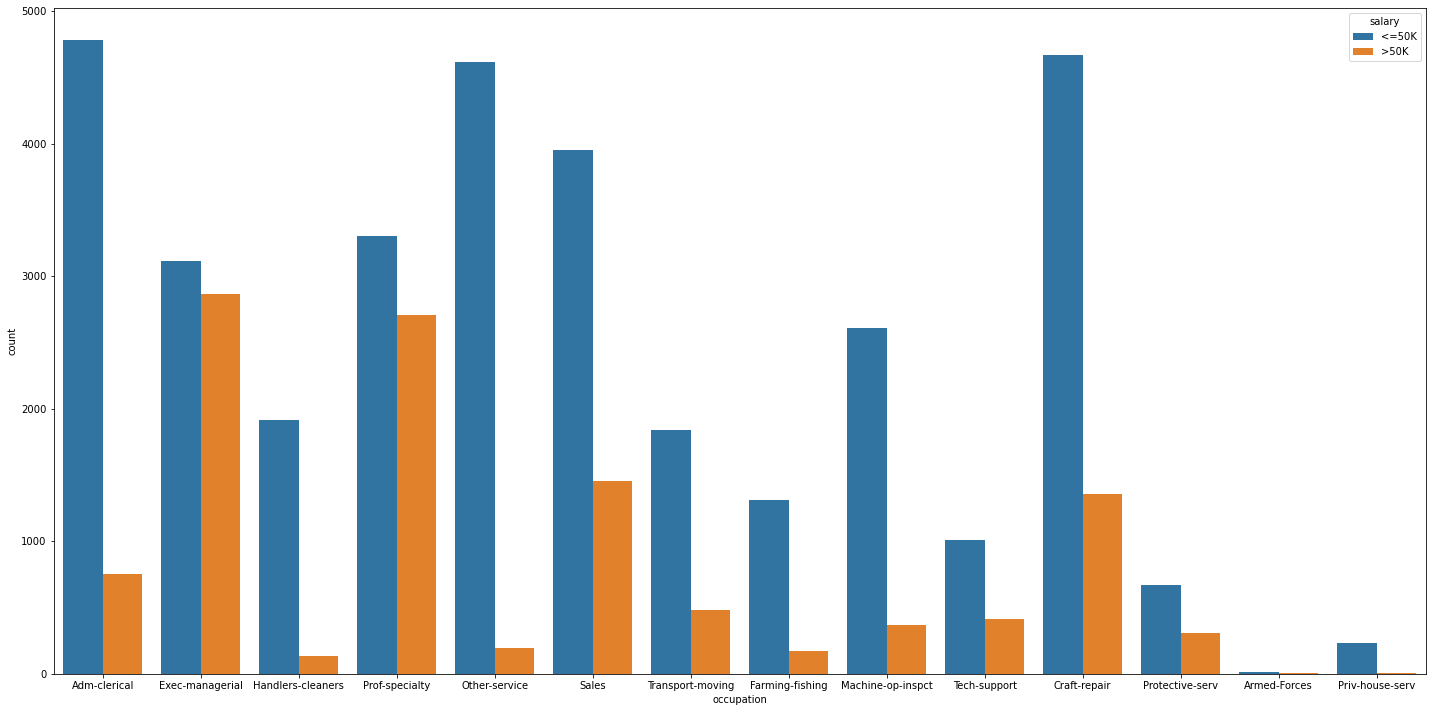

In [20]:
plt.figure(figsize=(20,10))
sns.countplot(x='occupation', hue='salary', data=df)
plt.tight_layout()
plt.show()

# Salaire par rapport a la race

les personnes de race blanche posséde nettement plus d'emplois que les autres race aux usa, plus de 25000 personnes gagnant mois de 50K, et plus de 10000 personnes gagnant plus, ce qui represente 75% de tous le dataset

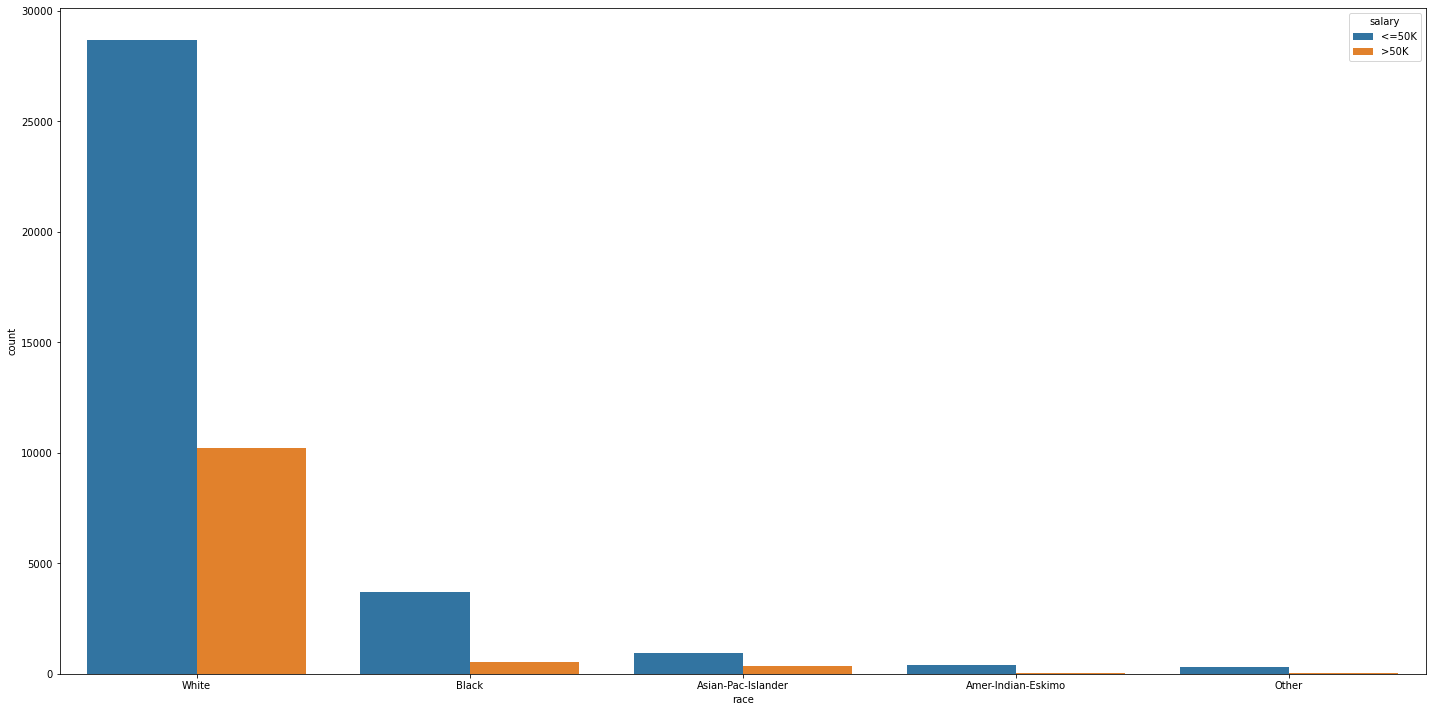

In [21]:
plt.figure(figsize=(20,10))
sns.countplot(x='race', hue='salary', data=df)
plt.tight_layout()
plt.show()

# Salaire par rapport a l'age

Pour les personnes gagnant plus de 50K leurs age entre 30 et 50 ans, par contre les moins de 50K entre 20 et 40

<AxesSubplot:xlabel='age', ylabel='salary'>

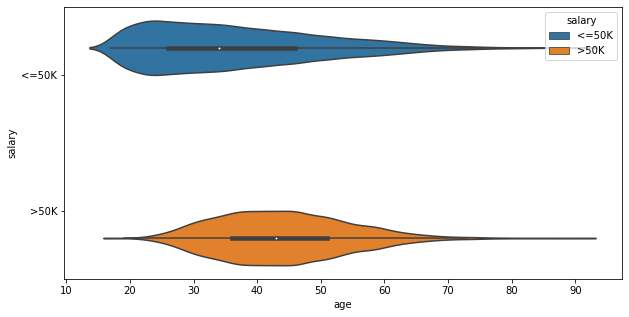

In [22]:
plt.figure(figsize=(10,5))
sns.violinplot(x='age',y='salary',hue='salary',data=df)

# Salaire par rapport a la situation familiale

les personnes Marrie sont representer a plus de 50% dans tout le dataset

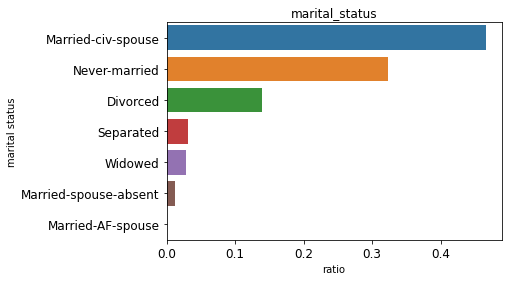

In [23]:
marital_status = df['marital-status'].value_counts(normalize=True)
sns.barplot(x=marital_status.values, y=marital_status.index)
plt.title('marital_status')
plt.xlabel('ratio')
plt.ylabel('marital status')
plt.tick_params(labelsize=12)
plt.show()

# Salaire par rapport au pays de naissance

Un fort déséquilibre entre le pays de naissance, ils existent plus de 90% de personnes de nationalité americaines qui travailles aux usa, avec ce feature nous avons décider de le binariser avec 0 si il est née aux USA, 1 sinon

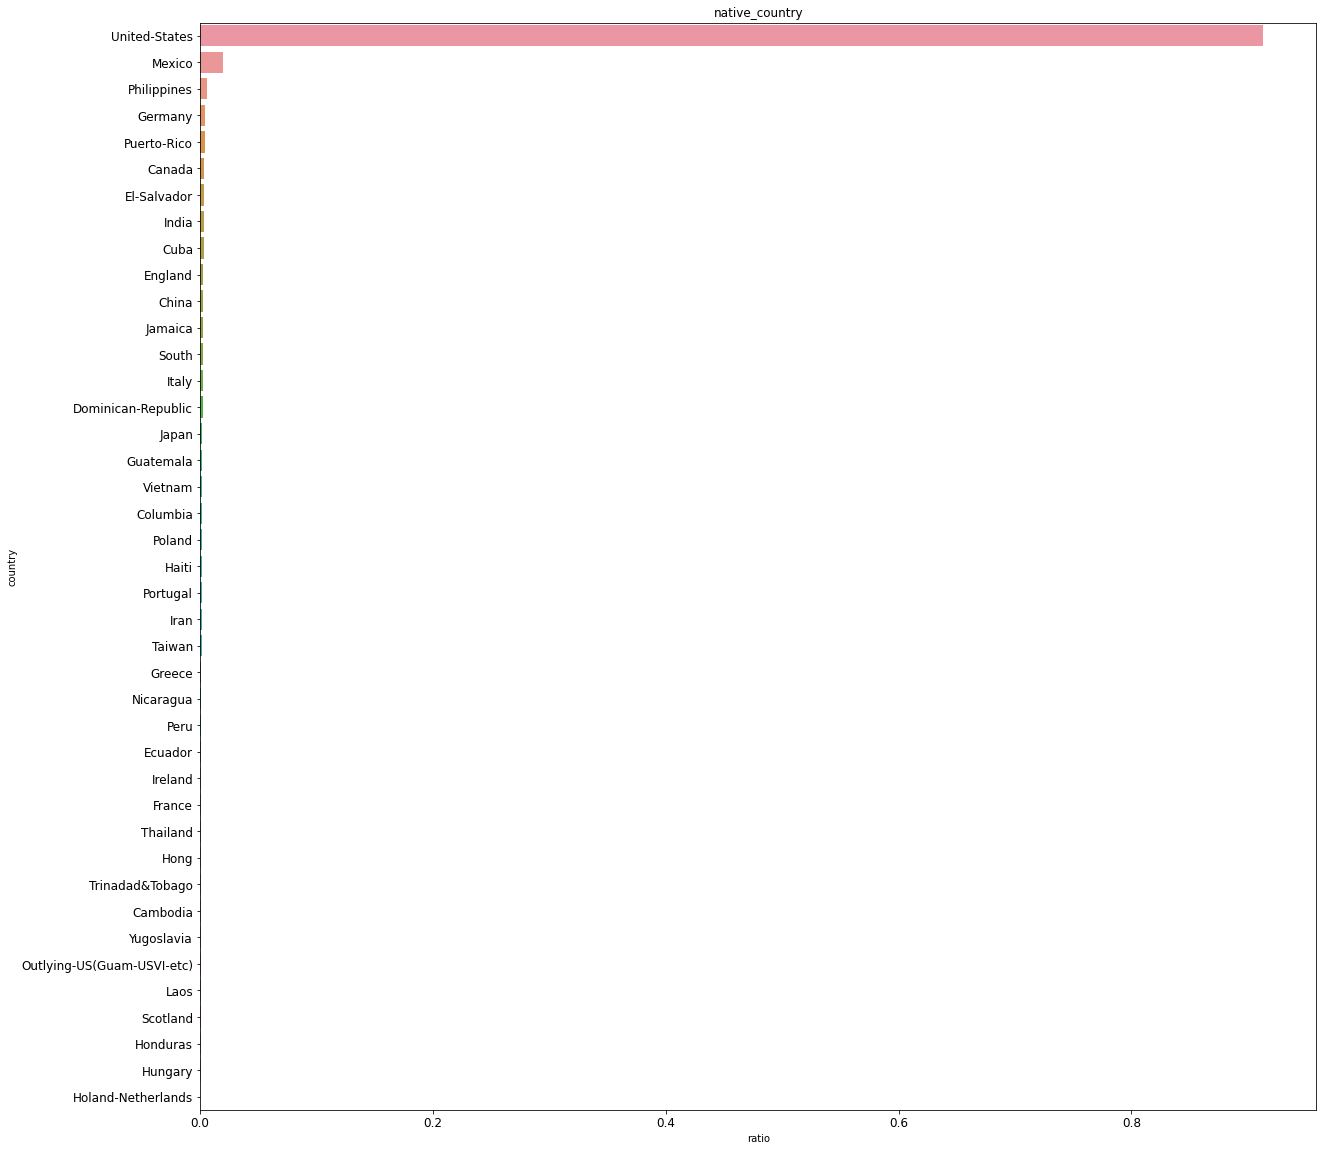

In [101]:
native_country = df['native-country'].value_counts(normalize=True)
plt.figure(figsize=(20,20))
sns.barplot(x=native_country.values, y=native_country.index)
plt.title('native_country')
plt.xlabel('ratio')
plt.ylabel('country')
plt.tick_params(labelsize=12)
plt.show()

# Définition de fonction utile

Comme nous avons dis précédemment la fmeasure est la métrique la plus informative dans ce genre de tache déséquilibrer, donc une fonction qui prend en entrer les prédictions et calcules, la précision, le rappel, l'accuracy et la f1 mesure, ainsi que la courbe ROC est définie ci-dessous:<br>
La fonction metric_calculator, calcule l'accuracy, la precision, le rappel, la fmeasure, la courbe roc sur les personnes gagnant plus de 50K\\$

In [124]:
def metric_calculator(predictions):
    tp = float(predictions.filter("prediction == 1.0 AND target == 1.0").count())
    fp = float(predictions.filter("prediction == 1.0 AND target == 0.0").count())
    tn = float(predictions.filter("prediction == 0.0 AND target == 0.0").count())
    fn = float(predictions.filter("prediction == 0.0 AND target == 1.0").count())
    evaluator=BinaryClassificationEvaluator(labelCol='target')
    Accuracy=(tp+tn)/(tp+fp+tn+fn)
    Precision= tp / (tp + fp)
    Recall=tp / (tp + fn)
    fmesure=2 * (Precision * Recall) / (Precision + Recall)
    ROC=evaluator.evaluate(predictions)

    metrics = spark.createDataFrame([
     ("TP", tp),
     ("FP", fp),
     ("TN", tn),
     ("FN", fn),
     ("Accuracy",Accuracy),
     ("Precision", Precision),
     ("Recall", Recall), 
     ("f-mesure",fmesure),
     ("ROC",ROC)],["metric", "value"])
    metrics.show()

La fonction ExtractFeatureNameImportance a pour but d'associer l'importance des poids des features d'un classifier a un nom de features. 

In [213]:
def ExtractFeatureNameImportance(featureImportances, data, featuresColName):
    list_extract = []
    for i in data.schema[featuresColName].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + data.schema[featuresColName].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImportances[x])
    ploter=(varlist.sort_values('score', ascending = False))
    plt.figure(figsize=(20,20))
    sns.barplot(x=ploter['score'], y=ploter['name'])
    plt.title('features importance')
    plt.xlabel('ratio')
    plt.ylabel('features')
    plt.tick_params(labelsize=12)
    plt.show()
    return ploter

Nous avions remarquer dans les statistiques précédentes que le native-country United-States est le plus présent que les autres nations avec un ratio de 0.913095 donc on transforme la colonne en boolean 0 si USA 1 dans les autres cas.

In [105]:
Adult_data=Adult_data.withColumn('native-country',when(col('native-country')=='United-States',0).otherwise(1))\
                     .withColumn('native-country',col('native-country').cast(IntegerType()))

# Transformation des données

Comme le dataset posséde des données catégoriels, nous allons donc appliquer un stringIndexer suivi d'un one hot a ces dernieres, sauf dans le cas du label au quel cas nous allons juste les binariser.
Nous allons donc les indexer, ensuite nous allons les transfomer en vecteur one hot, ensuite nous allons les assembler avec un vactorAssembler.

In [260]:
categorical_columns=[col_name for col_name,type_name in Adult_data.dtypes if type_name!= 'int' and col_name!='salary']
numerical_columns=[col_name for col_name,type_name in Adult_data.dtypes if type_name=='int']
categorical_columns_indexed=[c+'_indexed' for c in categorical_columns ]

In [261]:
stringIndexerIncome=StringIndexer(inputCol='salary',outputCol='target')
stringIndexer=StringIndexer(inputCols=categorical_columns,outputCols=categorical_columns_indexed)
oneHotIndexer=OneHotEncoder(inputCols=categorical_columns_indexed,outputCols=[c+'_encoded' for c in categorical_columns_indexed])
vectAssemble=VectorAssembler(inputCols=numerical_columns+oneHotIndexer.getOutputCols(),outputCol='features')

# Learn First Model

L'utilisation de seed dans le random split afin de travailler toujours avec les memes jeux de train et de test, nous prenons a peu pres 30% pour les données de test, et nous avons définie un pipeline.

# Logistic Regression

une fmesure de 0.67 ce qui est une performance pauvre, le modéle n'arrive pas bien a prédire les ou la personne gagnant plus de 50K

In [130]:
train,test=Adult_data.randomSplit([0.7,0.3],seed=1)
lr = LogisticRegression(featuresCol='features', labelCol="target")
piple=Pipeline(stages=[stringIndexerIncome,stringIndexer,oneHotIndexer,vectAssemble,lr])
model=piple.fit(train)
predictions = model.transform(test)

In [131]:
metric_calculator(predictions)

+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|            2053.0|
|       FP|             751.0|
|       TN|            9381.0|
|       FN|            1315.0|
| Accuracy|0.8469629629629629|
|Precision|0.7321683309557775|
|   Recall|0.6095605700712589|
| f-mesure|0.6652624756966947|
|      ROC|0.9057803677912363|
+---------+------------------+



# Random Forrest

Le modéle est encore moins bon avec une fmesure de 0.58, donc nous allons forcement pas utiliser ce modéle.

In [134]:
train,test=Adult_data.randomSplit([0.7,0.3],seed=1)
rf = RandomForestClassifier(featuresCol='features', labelCol="target")
piple=Pipeline(stages=[stringIndexerIncome,stringIndexer,oneHotIndexer,vectAssemble,rf])
model=piple.fit(train)
predictions = model.transform(test)

In [135]:
metric_calculator(predictions)

+---------+-------------------+
|   metric|              value|
+---------+-------------------+
|       TP|             1585.0|
|       FP|              451.0|
|       TN|             9681.0|
|       FN|             1783.0|
| Accuracy| 0.8345185185185185|
|Precision| 0.7784872298624754|
|   Recall|0.47060570071258906|
| f-mesure| 0.5866025166543302|
|      ROC| 0.8860034480721458|
+---------+-------------------+



# Linear SVM

Performace en fmesure plus ou moins équivalente a la logisticRegression, pas trés efficace aussi.

In [136]:
train,test=Adult_data.randomSplit([0.7,0.3],seed=1)
ls = LinearSVC(featuresCol='features', labelCol="target")
piple=Pipeline(stages=[stringIndexerIncome,stringIndexer,oneHotIndexer,vectAssemble,ls])
model=piple.fit(train)
predictions = model.transform(test)

In [137]:
metric_calculator(predictions)

+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|            1982.0|
|       FP|             686.0|
|       TN|            9446.0|
|       FN|            1386.0|
| Accuracy|0.8465185185185186|
|Precision|0.7428785607196402|
|   Recall| 0.588479809976247|
| f-mesure| 0.656726308813784|
|      ROC|0.9034836359578503|
+---------+------------------+



# GBTClassifier

les Gradient Boosting Trees ont jusqu'a present la meilleurs performances en fmesure , qui est de 0.67

In [158]:
train,test=Adult_data.randomSplit([0.7,0.3],seed=1)
gbt= GBTClassifier(featuresCol='features', labelCol="target",maxMemoryInMB=1024)
piple=Pipeline(stages=[stringIndexerIncome,stringIndexer,oneHotIndexer,vectAssemble,gbt])
model=piple.fit(train)
predictions = model.transform(test)

In [159]:
metric_calculator(predictions)

+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|            2018.0|
|       FP|             619.0|
|       TN|            9513.0|
|       FN|            1350.0|
| Accuracy|0.8541481481481481|
|Precision|0.7652635570724308|
|   Recall|0.5991686460807601|
| f-mesure|0.6721065778517902|
|      ROC|0.9109388494673163|
+---------+------------------+



# Amelioration et tuning

Nous allons décider de tuner les hyperparametres sur le maxdepth, maxbins et maxiter de les arbres des gbt, nous avons encore ameliorer notre modéle qui a une performance de 0.69

In [160]:
train,test=Adult_data.randomSplit([0.7,0.3],seed=1)
gbt= GBTClassifier(featuresCol='features', labelCol="target",maxMemoryInMB=1024)
piple=Pipeline(stages=[stringIndexerIncome,stringIndexer,oneHotIndexer,vectAssemble,gbt])

In [161]:
grid=ParamGridBuilder()\
                .addGrid(gbt.maxDepth, [d for d in range(4,10,2)])\
                .addGrid(gbt.maxBins, [d for d in range(30,36,3)])\
                .addGrid(gbt.maxIter, [d for d in range(20,60,20)]).build()

In [162]:
crossval = CrossValidator(estimator=piple,
                          estimatorParamMaps=grid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="target",metricName='f1'),
                          numFolds=3)

cvModel = crossval.fit(train)

In [163]:
predictions = cvModel.transform(test)

In [164]:
metric_calculator(predictions)

+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|            2114.0|
|       FP|             648.0|
|       TN|            9484.0|
|       FN|            1254.0|
| Accuracy|0.8591111111111112|
|Precision|0.7653874004344677|
|   Recall|0.6276722090261283|
| f-mesure|0.6897226753670473|
|      ROC|0.9145050476231559|
+---------+------------------+



meilleurs parametres sont maxbins=33, maxdepth=6, maxiter=40

In [178]:
print(cvModel.bestModel.stages[-1].getMaxBins())
print(cvModel.bestModel.stages[-1].getMaxDepth())
print(cvModel.bestModel.stages[-1].getMaxIter())
#33
#6
#40

33
6
40


# Identification des attributs non pertinents & Feature selection

L'utilisation de la matrice de corrélation afin d'évaluer la dépendence entre la variable target et les autres variables en même temps. Le résultat est une table contenant les coefficients de corrélation entre chaque variable et les autres.<br>
il est tout à fait visible que dans les variables numeriques la target est indépendante de fnlwgt, donc nous pouvons essaie de voir si les performances ce matiennent si nous supprimer cette colonne.<br>
Ensuite dans les catégorielles marital_status, occupation, relationship, la race, le sexe, native_country ont une relation minimale ou nulle avec le target de sortie final nous pouvons donc de supprimer quelque une de ces colonnes pour voir si la performance ce stabilise et ne s'effondre pas.

<AxesSubplot:>

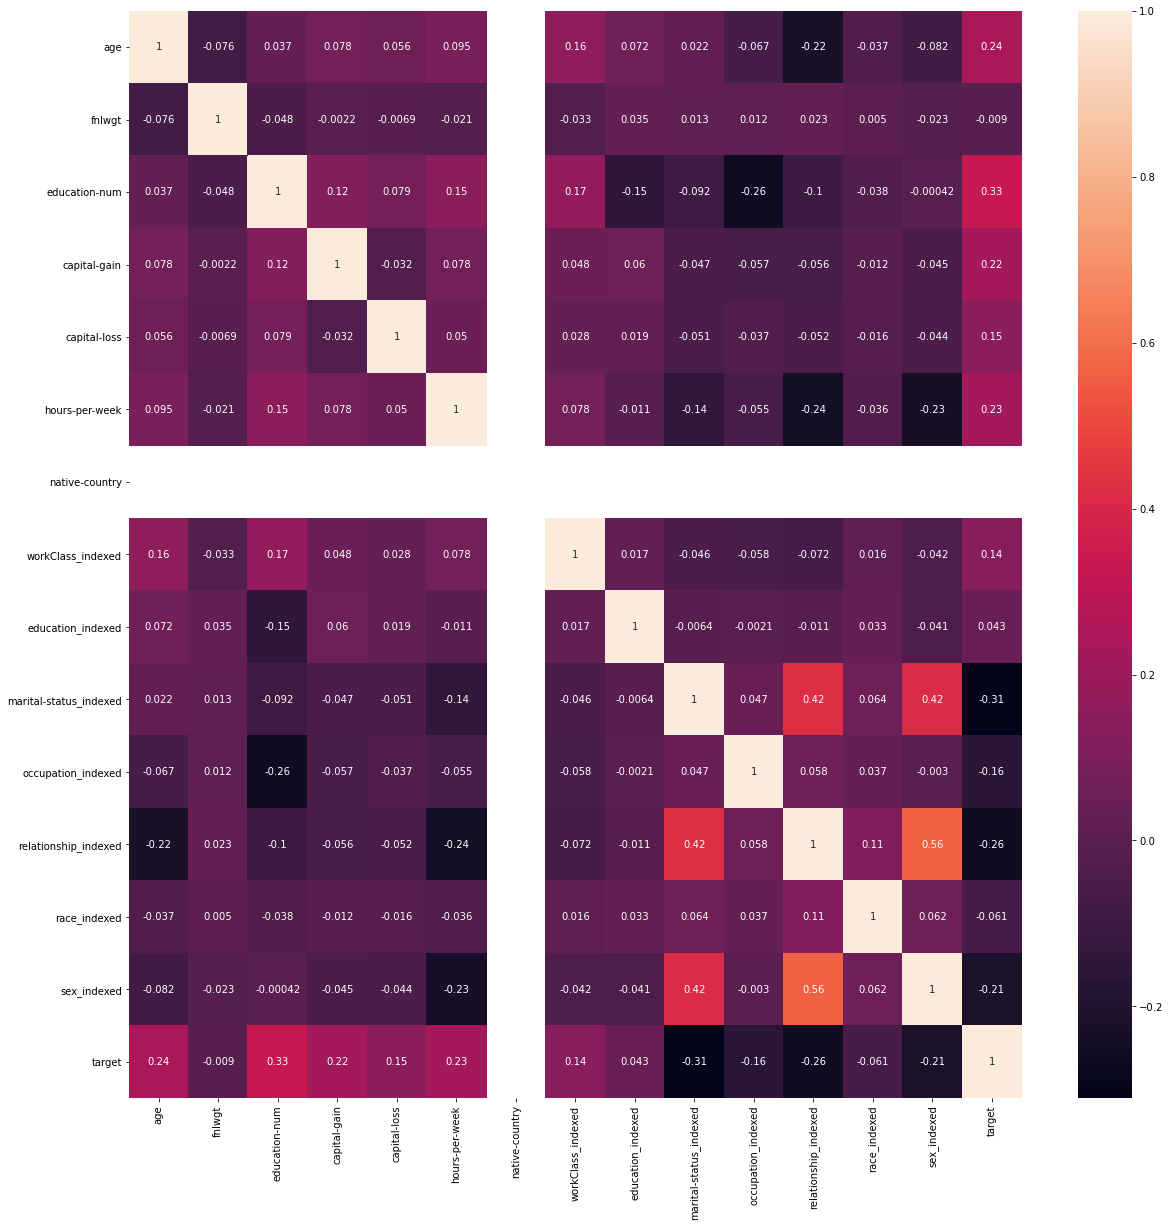

In [176]:
train,test=Adult_data.randomSplit([0.7,0.3],seed=1)
pipeline=Pipeline(stages=[stringIndexer,stringIndexerIncome])
data_train=pipeline.fit(train).transform(train)
plt.figure(figsize=(20,20))
sns.heatmap(data_train.toPandas().corr(), annot=True)

Combiner avec les features importances du gbt, nous avons tester de supprimer plein de combinaison, mais avec 'native-country','fnlwgt','race' nous obtenons le meilleurs modéle jusqu'a présent obtenu.

+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|            2114.0|
|       FP|             648.0|
|       TN|            9484.0|
|       FN|            1254.0|
| Accuracy|0.8591111111111112|
|Precision|0.7653874004344677|
|   Recall|0.6276722090261283|
| f-mesure|0.6897226753670473|
|      ROC|0.9145090330206594|
+---------+------------------+



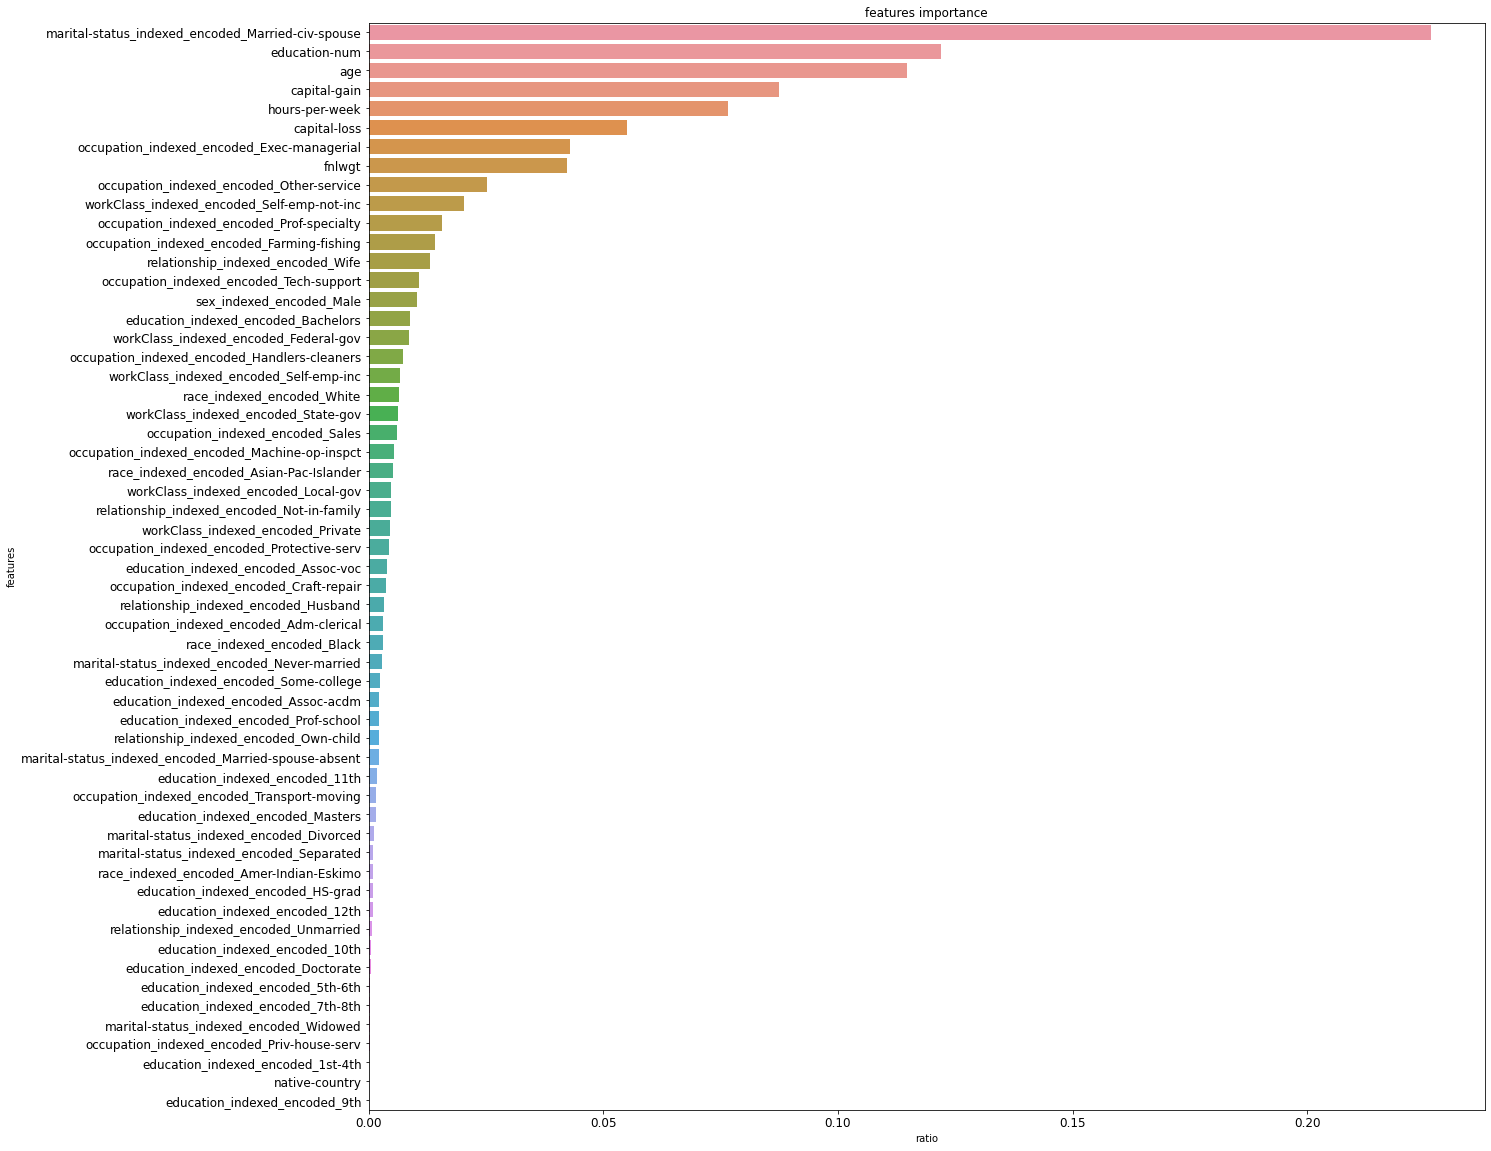

,idx,name,score
28,28,marital-status_indexed_encoded_Married-civ-spouse,0.226459
2,2,education-num,0.121890
0,0,age,0.114770
3,3,capital-gain,0.087548
5,5,hours-per-week,0.076593
4,4,capital-loss,0.055020
36,36,occupation_indexed_encoded_Exec-managerial,0.042993
1,1,fnlwgt,0.042237
39,39,occupation_indexed_encoded_Other-service,0.025332
8,8,workClass_indexed_encoded_Self-emp-not-inc,0.020410


In [262]:
train,test=Adult_data.randomSplit([0.7,0.3],seed=1)
gbt= GBTClassifier(featuresCol='features', labelCol="target",maxMemoryInMB=1024,maxBins=33,maxIter=40,maxDepth=6)
piple=Pipeline(stages=[stringIndexerIncome,stringIndexer,oneHotIndexer,vectAssemble,gbt])
model=piple.fit(train)
predictions = model.transform(test)
metric_calculator(predictions)
ExtractFeatureNameImportance(model.stages[-1].featureImportances, predictions, "features")

In [267]:
data_droped=Adult_data.drop('native-country','fnlwgt','race')

categorical_columns=[col_name for col_name,type_name in data_droped.dtypes if type_name!= 'int' and col_name!='salary']
numerical_columns=[col_name for col_name,type_name in data_droped.dtypes if type_name=='int']
categorical_columns_indexed=[c+'_indexed' for c in categorical_columns ]

stringIndexerIncome=StringIndexer(inputCol='salary',outputCol='target')
stringIndexer=StringIndexer(inputCols=categorical_columns,outputCols=categorical_columns_indexed)
oneHotIndexer=OneHotEncoder(inputCols=categorical_columns_indexed,outputCols=[c+'_encoded' for c in categorical_columns_indexed])
vectAssemble=VectorAssembler(inputCols=numerical_columns+oneHotIndexer.getOutputCols(),outputCol='features')

+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|            2116.0|
|       FP|             649.0|
|       TN|            9482.0|
|       FN|            1253.0|
| Accuracy|0.8591111111111112|
|Precision|0.7652802893309223|
|   Recall|0.6280795488275452|
| f-mesure|0.6899250081512879|
|      ROC|0.9146757031712115|
+---------+------------------+



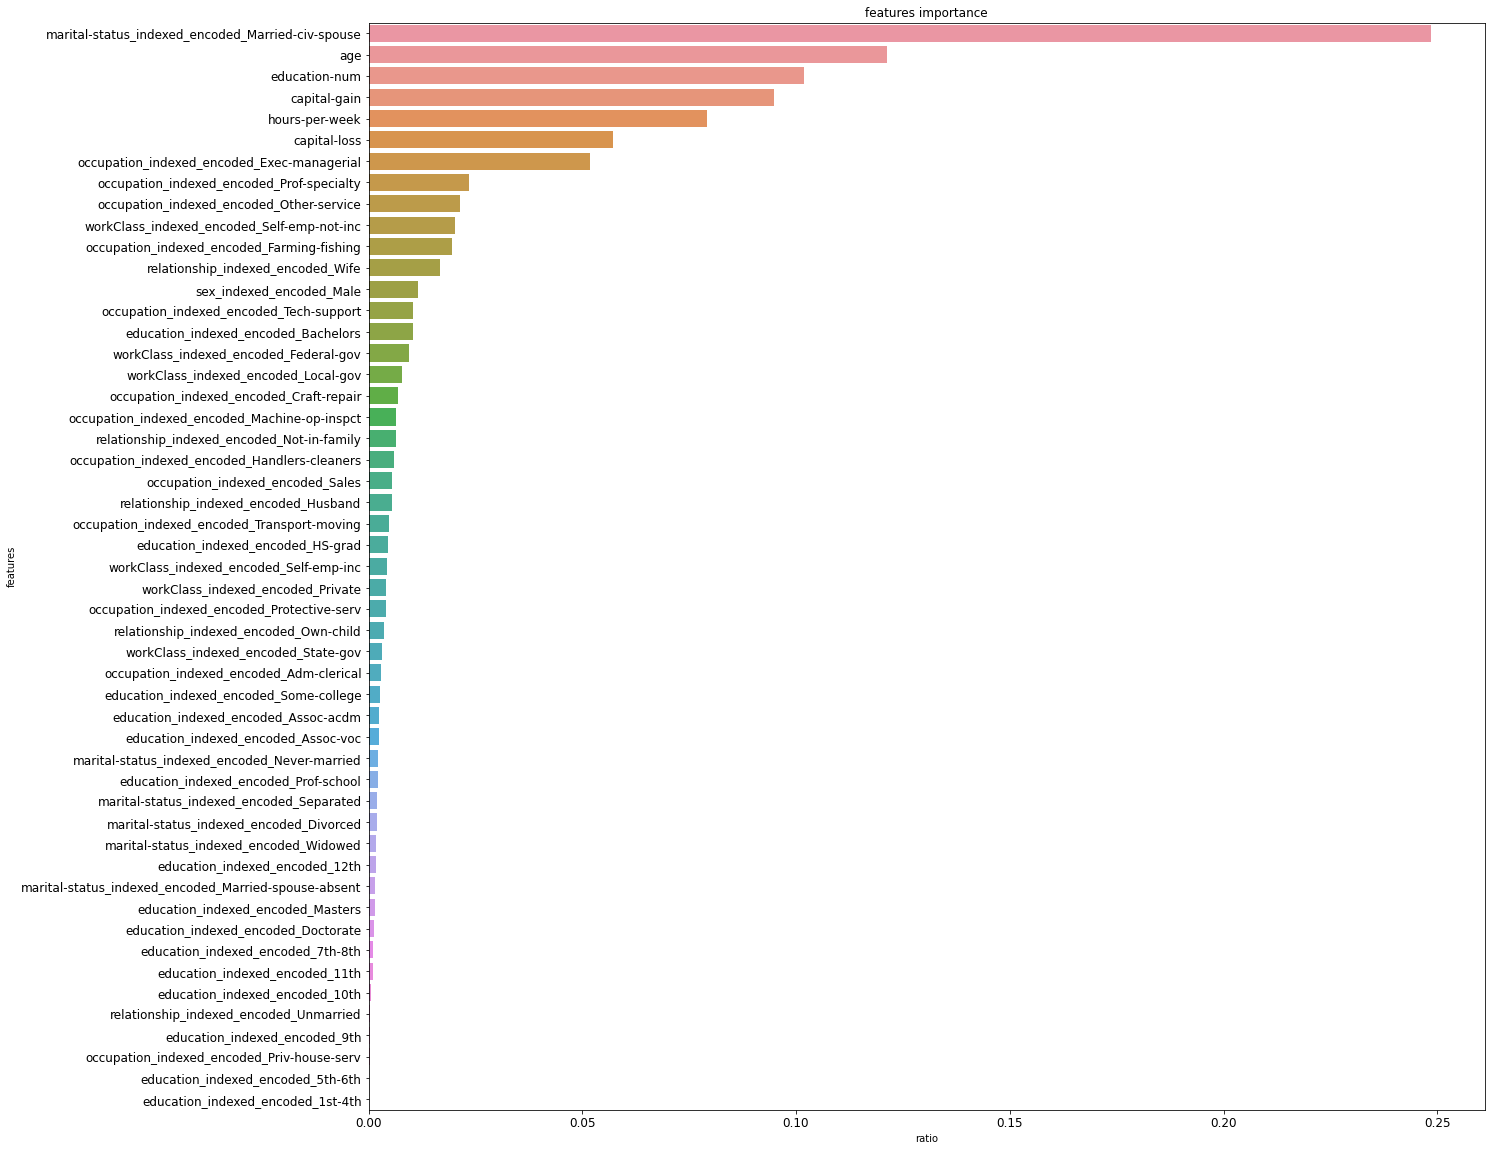

,idx,name,score
26,26,marital-status_indexed_encoded_Married-civ-spouse,0.248630
0,0,age,0.121217
1,1,education-num,0.101864
2,2,capital-gain,0.094734
4,4,hours-per-week,0.079155
3,3,capital-loss,0.057128
34,34,occupation_indexed_encoded_Exec-managerial,0.051829
32,32,occupation_indexed_encoded_Prof-specialty,0.023495
37,37,occupation_indexed_encoded_Other-service,0.021289
6,6,workClass_indexed_encoded_Self-emp-not-inc,0.020239


In [268]:
train,test=data_droped.randomSplit([0.7,0.3],seed=1)
gbt= GBTClassifier(featuresCol='features', labelCol="target",maxMemoryInMB=1024,maxBins=33,maxIter=40,maxDepth=6)
piple=Pipeline(stages=[stringIndexerIncome,stringIndexer,oneHotIndexer,vectAssemble,gbt])
model=piple.fit(train)
predictions = model.transform(test)
metric_calculator(predictions)
ExtractFeatureNameImportance(model.stages[-1].featureImportances, predictions, "features")

# UnderSampling

Dans cette méthode nous allons prendre le meme nombre d'echantillon entre >50K et<=50K, donc a peu pres 11208, tout en supprimant les colonnes 'native-country','fnlwgt','race', une performance de 0.82 est obtenu une net amelioration qui est du au fait de ne pas prendre tout les données des personnes gagnant moins de 50K. <br>
Les fonctions takeSample prend un nombre num d'echantillon, et la fonction reduce fait l'union des dataframes, nous les ordonnant aleatoirement avec orderBy(rand())

In [288]:
data_droped=Adult_data.drop('native-country','fnlwgt','race')
sp_inf=data_droped.where('salary like "<=50K"')
sp_sup=data_droped.where('salary like ">50K"')
number=sp_sup.count()
sp_inf_resampled=spark.createDataFrame(sp_inf.rdd.takeSample(withReplacement=False,num=number))
data_sampled=reduce(DataFrame.union,[sp_inf_resampled,sp_sup]).orderBy(rand()) 

In [289]:
data_sampled.groupBy('salary').count().show()

+------+-----+
|salary|count|
+------+-----+
| <=50K|11208|
|  >50K|11208|
+------+-----+



In [290]:
categorical_columns=[col_name for col_name,type_name in data_droped.dtypes if type_name!= 'int' and col_name!='salary']
numerical_columns=[col_name for col_name,type_name in data_droped.dtypes if type_name=='int']
categorical_columns_indexed=[c+'_indexed' for c in categorical_columns ]
stringIndexerIncome=StringIndexer(inputCol='salary',outputCol='target')
stringIndexer=StringIndexer(inputCols=categorical_columns,outputCols=categorical_columns_indexed)
oneHotIndexer=OneHotEncoder(inputCols=categorical_columns_indexed,outputCols=[c+'_encoded' for c in categorical_columns_indexed])
vectAssemble=VectorAssembler(inputCols=numerical_columns+oneHotIndexer.getOutputCols(),outputCol='features')

+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|            2715.0|
|       FP|             451.0|
|       TN|            2898.0|
|       FN|             711.0|
| Accuracy|0.8284870848708487|
|Precision|   0.8575489576753|
|   Recall|0.7924693520140105|
| f-mesure|0.8237257281553398|
|      ROC|0.9118927816844019|
+---------+------------------+



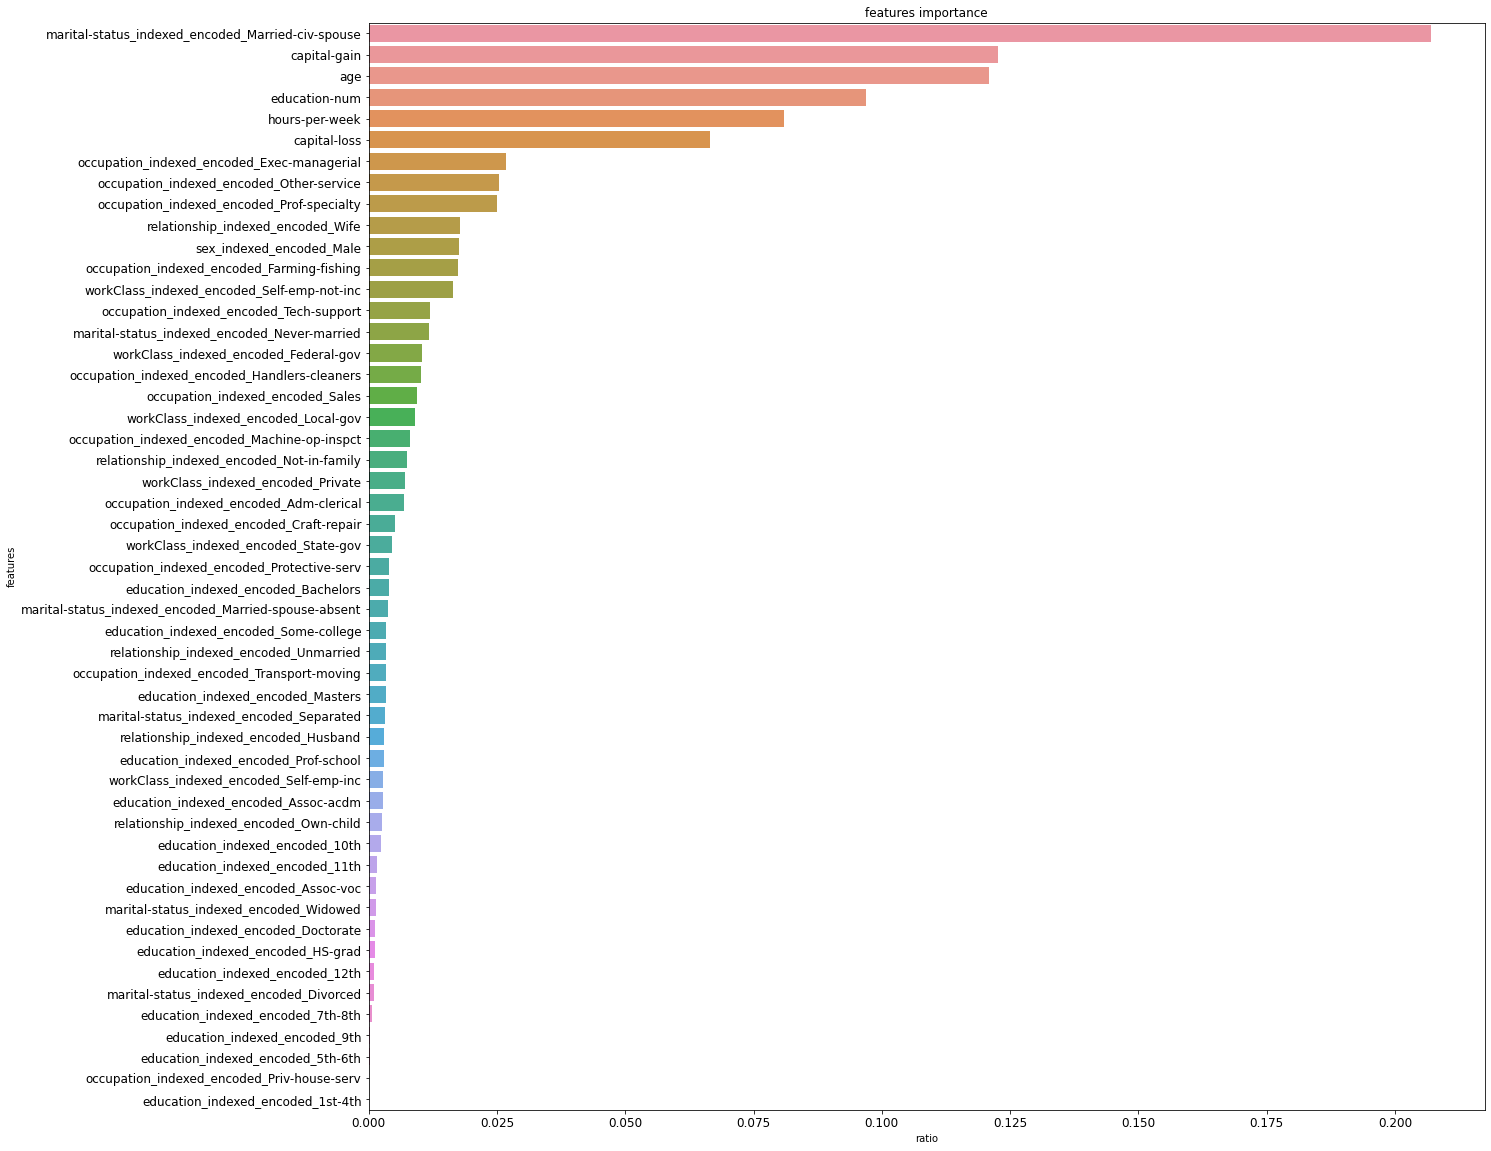

,idx,name,score
26,26,marital-status_indexed_encoded_Married-civ-spouse,0.207084
2,2,capital-gain,0.122662
0,0,age,0.120926
1,1,education-num,0.096891
4,4,hours-per-week,0.080990
3,3,capital-loss,0.066493
32,32,occupation_indexed_encoded_Exec-managerial,0.026845
37,37,occupation_indexed_encoded_Other-service,0.025430
33,33,occupation_indexed_encoded_Prof-specialty,0.025067
49,49,relationship_indexed_encoded_Wife,0.017881


In [291]:
train,test=data_sampled.randomSplit([0.7,0.3],seed=1)
gbt= GBTClassifier(featuresCol='features', labelCol="target",maxMemoryInMB=1024,maxBins=33,maxIter=40,maxDepth=6)
piple=Pipeline(stages=[stringIndexerIncome,stringIndexer,oneHotIndexer,vectAssemble,gbt])
model=piple.fit(train)
predictions = model.transform(test)
metric_calculator(predictions)
ExtractFeatureNameImportance(model.stages[-1].featureImportances, predictions, "features")

# OverSampling

Avec la méthode de oversampling nous allons donc laisser les données des personnes gagnant moins de 50K mais nous allons donner plus de poids au personnes gagnant plus de 50K, les données sont donc équivalent avec 34014, la performance en fmesure est de 0.84 nous avons encore améliorer notre modéle.

In [297]:
data_droped=Adult_data.drop('native-country','fnlwgt','race')
sp_inf=data_droped.where('salary like "<=50K"')
sp_sup=data_droped.where('salary like ">50K"')
number=sp_inf.count()-sp_sup.count()
###########################################Reduce & Shuffle Data by rand() column###########################################
sp_sup_resampled=spark.createDataFrame(sp_sup.rdd.takeSample(withReplacement=True,num=number))
data_sampled=reduce(DataFrame.union,[sp_inf,sp_sup,sp_sup_resampled]).orderBy(rand())  

In [298]:
categorical_columns=[col_name for col_name,type_name in data_droped.dtypes if type_name!= 'int' and col_name!='salary']
numerical_columns=[col_name for col_name,type_name in data_droped.dtypes if type_name=='int']
categorical_columns_indexed=[c+'_indexed' for c in categorical_columns ]
stringIndexerIncome=StringIndexer(inputCol='salary',outputCol='target')
stringIndexer=StringIndexer(inputCols=categorical_columns,outputCols=categorical_columns_indexed)
oneHotIndexer=OneHotEncoder(inputCols=categorical_columns_indexed,outputCols=[c+'_encoded' for c in categorical_columns_indexed])
vectAssemble=VectorAssembler(inputCols=numerical_columns+oneHotIndexer.getOutputCols(),outputCol='features')

In [299]:
data_sampled.groupBy('salary').count().show()

+------+-----+
|salary|count|
+------+-----+
| <=50K|34014|
|  >50K|34014|
+------+-----+



+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|            8991.0|
|       FP|            2070.0|
|       TN|            8168.0|
|       FN|            1324.0|
| Accuracy|0.8348659563080816|
|Precision|0.8128559804719284|
|   Recall|0.8716432380029084|
| f-mesure|0.8412238023952097|
|      ROC|0.9196427734414393|
+---------+------------------+



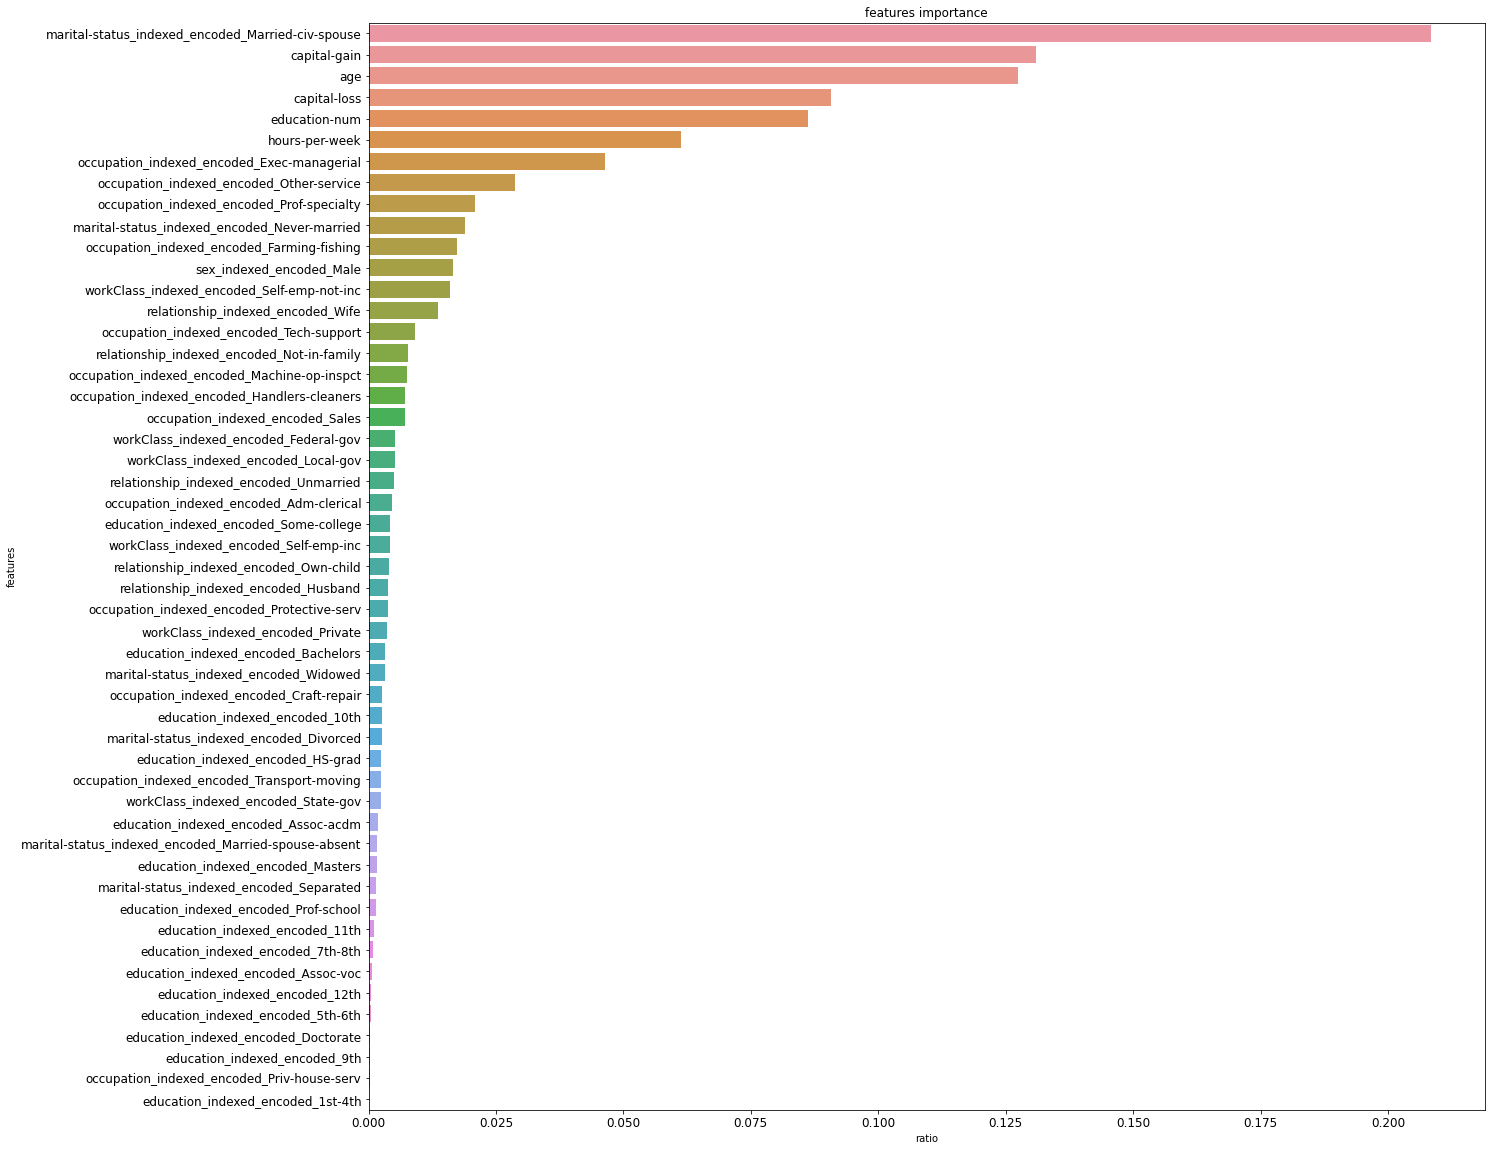

,idx,name,score
26,26,marital-status_indexed_encoded_Married-civ-spouse,0.208536
2,2,capital-gain,0.130880
0,0,age,0.127497
3,3,capital-loss,0.090743
1,1,education-num,0.086239
4,4,hours-per-week,0.061253
32,32,occupation_indexed_encoded_Exec-managerial,0.046295
37,37,occupation_indexed_encoded_Other-service,0.028662
33,33,occupation_indexed_encoded_Prof-specialty,0.020835
27,27,marital-status_indexed_encoded_Never-married,0.018942


In [300]:
train,test=data_sampled.randomSplit([0.7,0.3],seed=1)
gbt= GBTClassifier(featuresCol='features', labelCol="target",maxMemoryInMB=1024,maxBins=33,maxIter=40,maxDepth=6)
piple=Pipeline(stages=[stringIndexerIncome,stringIndexer,oneHotIndexer,vectAssemble,gbt])
model=piple.fit(train)
predictions = model.transform(test)
metric_calculator(predictions)
ExtractFeatureNameImportance(model.stages[-1].featureImportances, predictions, "features")